In [212]:
%matplotlib inline
import shell_model
import shells

from spectral_cube import SpectralCube
import astropy.units as u
from astropy.io import fits
from aplpy import FITSFigure
import numpy as np
import matplotlib.pyplot as plt

<Quantity 13.9 km / s>

## Extract Subcubes Around Shells

In [404]:
cubefile12co = "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits"
regionfile = "../shell_candidates/AllShells.reg"


# For Shell 18
n=17
shell_list = shells.get_shells()
shell = shell_list[n]
subcubes = shells.subcubes_from_ds9(cube=cubefile12co,
                                    region_file=regionfile,
                                    pad_factor=1.5, shape='square')
subcube_12co = subcubes[n]

## Set-up Model Parameters

In [437]:
outfile = '../turbulent_model/shell18_particles.fits'
pars = {
    'outfile':"'{}'".format(outfile),
    'dist':414*u.pc, # pc
    'pix_size':7.5*u.arcsec, # arcsec
    'vstep':0.099*u.km/u.s, # km/s
    'acen':shell.ra, # deg
    'dcen':shell.dec, # deg
    'R':0.22*u.pc, # pc
    'dr':0.2*u.pc, # pc
    'vexp':2.2*u.km/u.s, # km/s
    'v0':13.6*u.km/u.s, # km/s
    'method':'sample',
    'write_fits':False,
    'samples_per_voxel':27,
    'pad_channels':5
    }
pixels_per_R = np.floor((pars['R'] + pars['dr']/2.) /\
                        (pars['dist']*pars['pix_size'].to(u.rad).value)).value

#pars['pad_pixels'] = (subcube_12co.shape[1] - 2*pixels_per_R )/2

## Run Model and Normalize Model and Observed Shell Cubes

In [438]:
cube_model = SpectralCube.read(shell_model.ppv_model(**pars))
# cube_obs = subcube_12co.subcube(cube_model.longitude_extrema[1],
#                                 cube_model.longitude_extrema[0],
#                                 cube_model.latitude_extrema[0],
#                                 cube_model.latitude_extrema[1],
#                                 cube_model.spectral_extrema[0],
#                                 cube_model.spectral_extrema[1])
cube_obs = subcube_12co.subcube('min', 'max', 'min', 'max',
                                 cube_model.spectral_extrema[0],
                                 cube_model.spectral_extrema[1]
                               )
#cube_model = cube_model.reproject(cube_obs.header)
cube_model /= cube_model.max()
cube_obs /= cube_obs.max()
#cube_model.header


## Show Observed and Model Moment 0 Maps

INFO: Auto-setting vmin to  5.192e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.152e+03 [aplpy.core]


INFO: Auto-setting vmin to -2.873e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.189e-01 [aplpy.core]


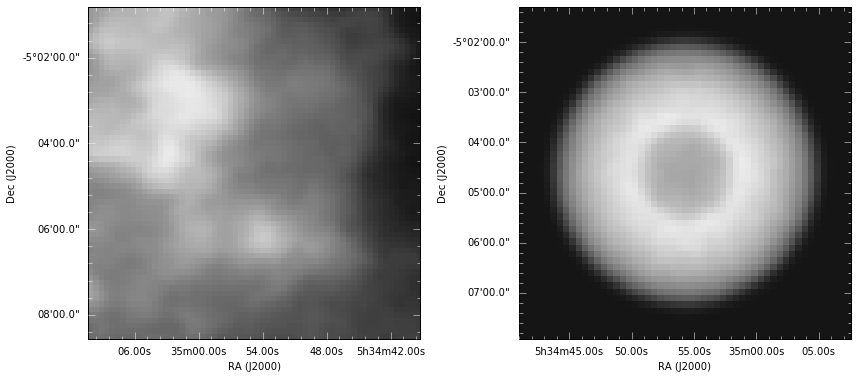

In [439]:
fig = plt.figure(figsize=(12,6))
figobs = FITSFigure(cube_obs.moment0().hdu, figure=fig, subplot=(1,2,1))
figobs.show_grayscale()
figmodel = FITSFigure(cube_model.moment0().hdu, figure=fig, subplot=(1,2,2))
figmodel.show_grayscale()
fig.tight_layout()

## Make PV Diagrams and Normalize Them

In [446]:
pv_width = 3. * pars['pix_size']
#pv_length = 3. * (pars['R'] / pars['dist'])*u.rad
pv_length = 3. * shell.radius
pv_average_obs = shells.pv_average(
    cube=cube_obs,#cube_obs.spectral_slab(cube_model.spectral_extrema[0], cube_model.spectral_extrema[1]),
    ra_center=pars['acen'], dec_center=pars['dcen'],
    width=pv_width, length=pv_length, angle_step=90.*u.deg)

pv_model = shells.pv_slice(cube=cube_model, ra_center=pars['acen'],
                           dec_center=pars['dcen'], angle=0*u.deg,
                           width=pv_width, length=pv_length)

model = np.nan_to_num(pv_model.data, copy=False)
obs = np.nan_to_num(pv_average_obs.data, copy=False)
model = model/np.max(model)
#model[model > 0.] = 1.
obs = obs/np.max(obs)




(55, 61)



INFO: Auto-setting vmin to -1.176e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.484e-01 [aplpy.core]
INFO: Auto-setting vmin to -7.822e-02 [aplpy.core]
INFO: Auto-setting vmax to  8.683e-01 [aplpy.core]


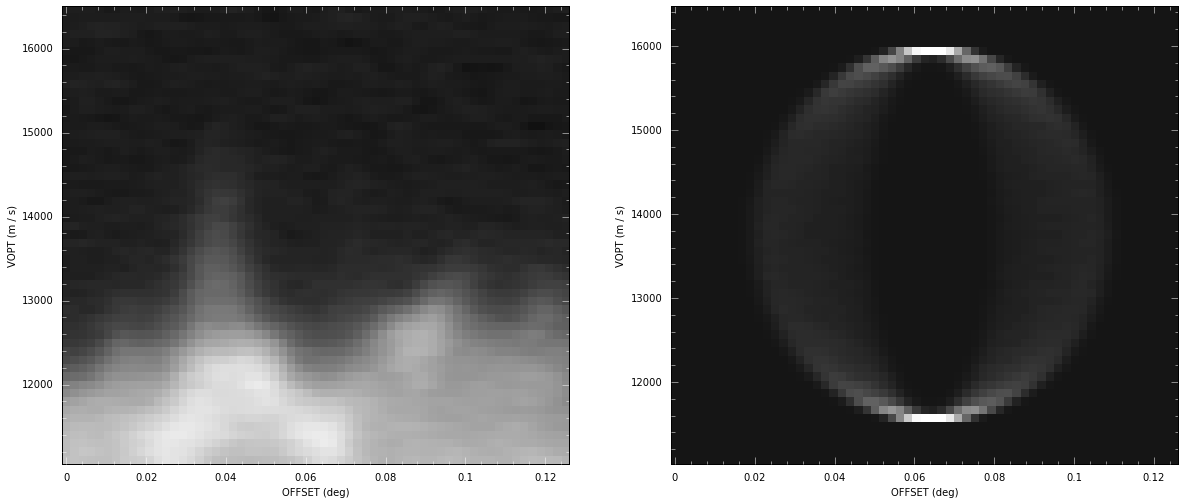

In [447]:
fig = plt.figure(figsize=(20,10))
figobs = FITSFigure(pv_average_obs, figure=fig, subplot=(1,2,1))
figobs.show_grayscale()
figmodel = FITSFigure(pv_model, figure=fig, subplot=(1,2,2))
figmodel.show_grayscale()

## Compute PV Residuals

INFO: Auto-setting vmin to -9.594e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.065e+00 [aplpy.core]
RMS Residual = 0.438113011274


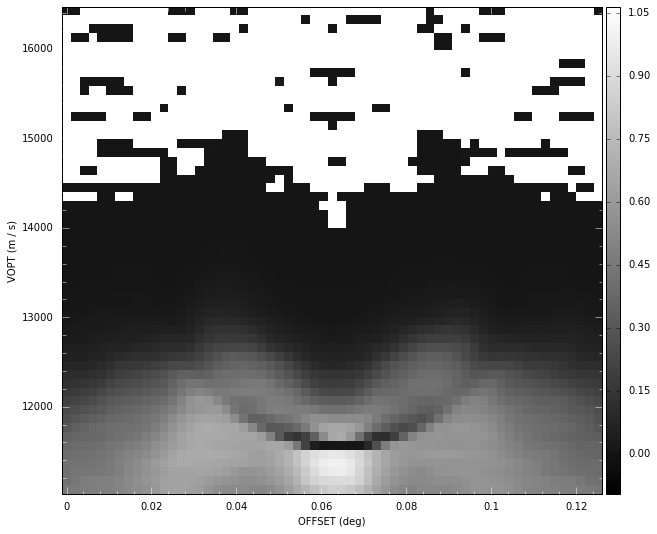

In [420]:
pv_resid =  obs - model
pv_resid[obs < 0.01] = np.nan
resid_squared = pv_resid ** 2.

fig = FITSFigure(fits.PrimaryHDU(resid_squared, header=pv_model.header))
g = fig.show_grayscale()
cb = fig.show_colorbar()
print("RMS Residual =", np.sqrt(np.nanmean(resid_squared)))

## Run a Grid of Models

In [443]:
dist = 414 * u.pc
pix_pc = dist * pars['pix_size'].to(u.radian).value
dv = 0.1 * u.km/u.s
R = dist * shell.radius.to(u.radian).value
dR = R
vexp = shell.vmax - shell.vmin


<Quantity 2.0999999999999996 km / s>

In [444]:
vexp_grid = np.arange(0.5*vexp.to(u.km/u.s).value, 2*vexp.to(u.km/u.s).value, 3. * dv.to(u.km/u.s).value)
#print(vexp_grid)
v0_grid = np.arange(0.8*shell.vmin.to(u.km/u.s).value, 1.2*shell.vmax.to(u.km/u.s).value, 3. * dv.to(u.km/u.s).value)
R_grid = np.arange(0.5 * R.to(u.pc).value, 2 * R.to(u.pc).value, 3. * pix_pc.value)
dR_grid = R_grid
v0_grid

array([  9.44,   9.74,  10.04,  10.34,  10.64,  10.94,  11.24,  11.54,
        11.84,  12.14,  12.44,  12.74,  13.04,  13.34,  13.64,  13.94,
        14.24,  14.54,  14.84,  15.14,  15.44,  15.74,  16.04,  16.34,
        16.64])






(55, 61)
0.154262889433

INFO: Auto-setting vmin to -6.885e-02 [aplpy.core]
INFO: Auto-setting vmax to  7.649e-01 [aplpy.core]
RMS Residual = 0.432556131782
0.199423283828

INFO: Auto-setting vmin to -9.497e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055e+00 [aplpy.core]
RMS Residual = 0.467612608323
0.244583678224

INFO: Auto-setting vmin to -9.473e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055e+00 [aplpy.core]
RMS Residual = 0.479785928387
0.289744072619

INFO: Auto-setting vmin to -9.500e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055e+00 [aplpy.core]
RMS Residual = 0.476338161923
0.334904467014

INFO: Auto-setting vmin to -9.502e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055e+00 [aplpy.core]
RMS Residual = 0.46706145266
0.38006486141

INFO: Auto-setting vmin to -9.502e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055e+00 [aplpy.core]
RMS Residual = 0.462919057455
0.425225255805

INFO: Auto-setting vmin to -9.503e-02 [aplpy.core]
INFO: Auto-setting vmax to  1.055

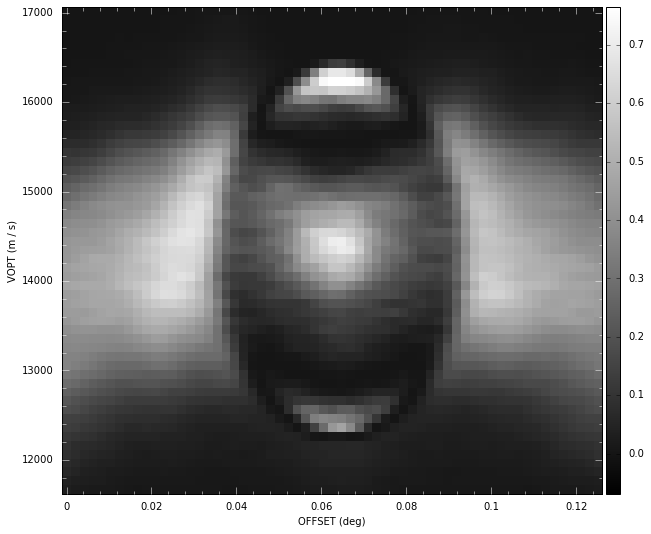

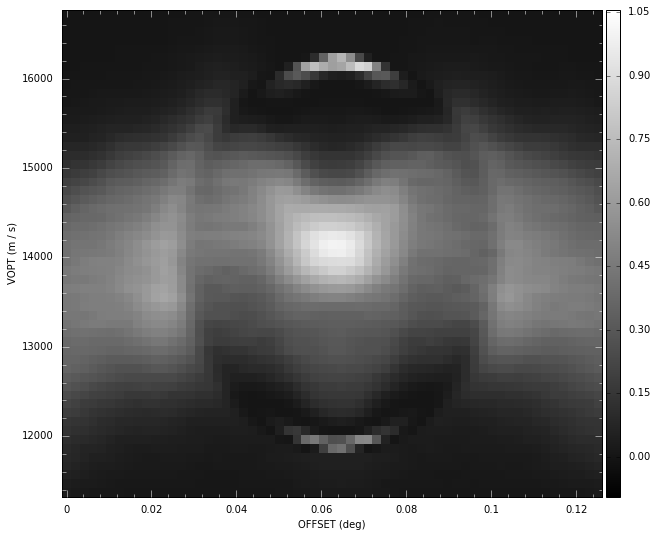

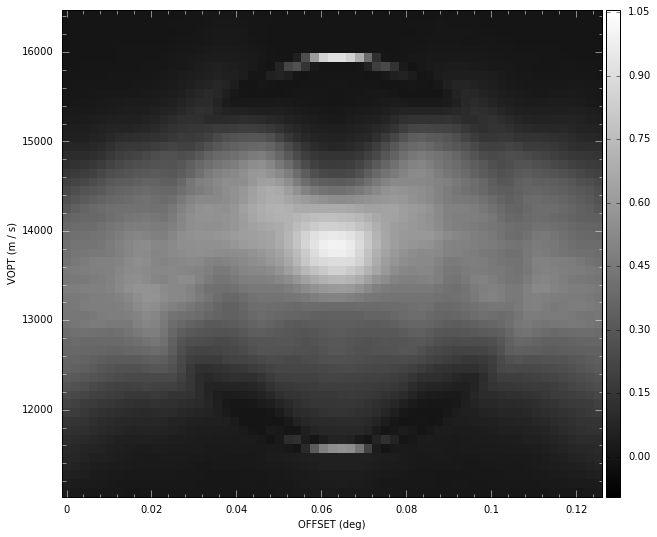

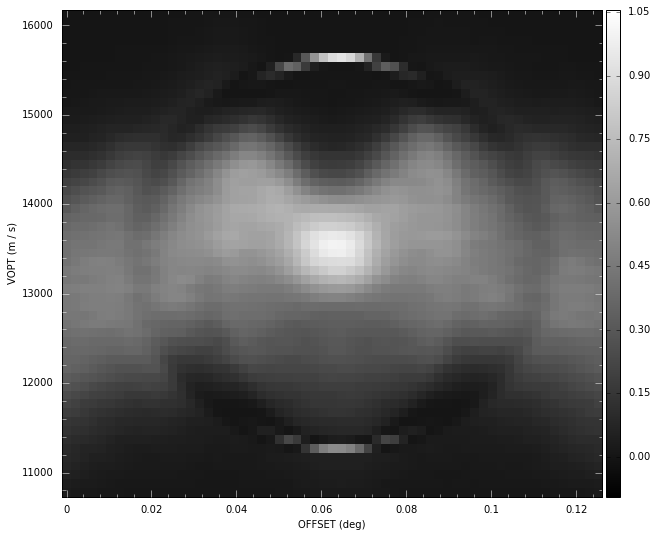

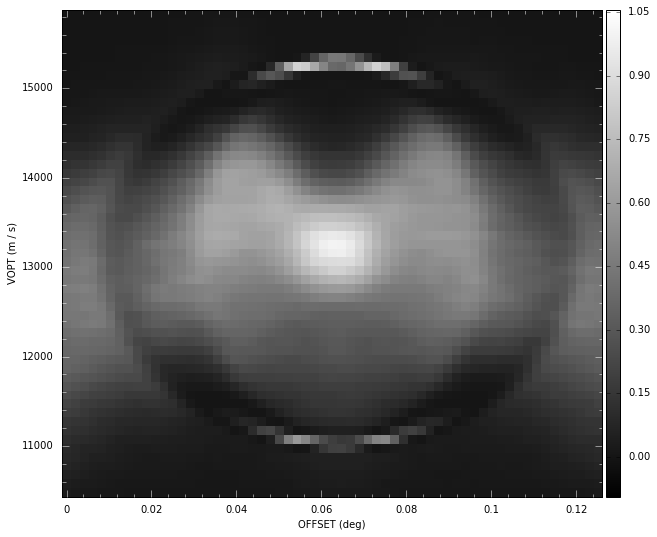

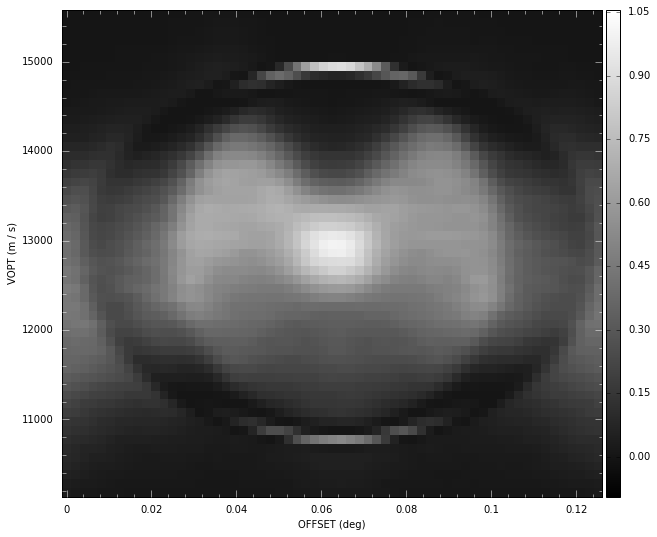

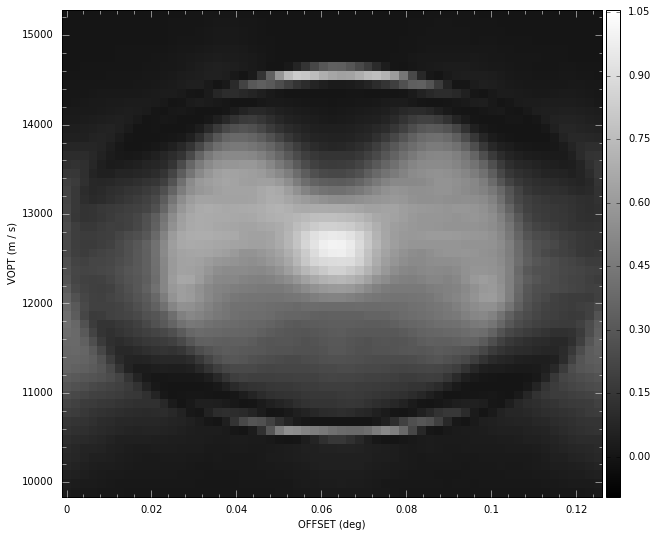

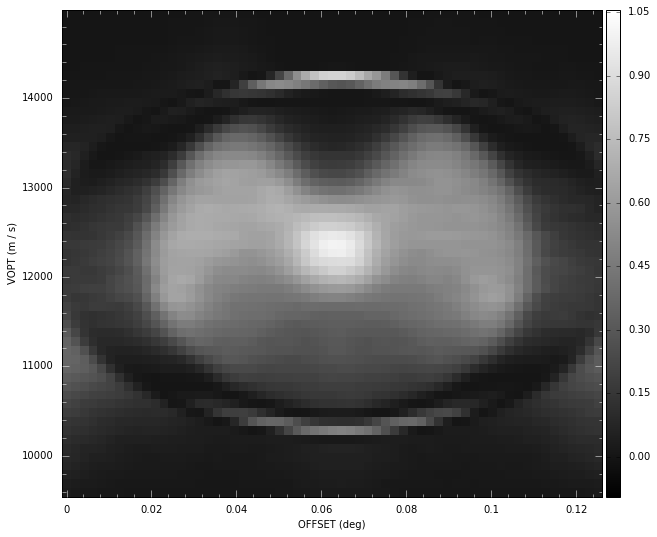

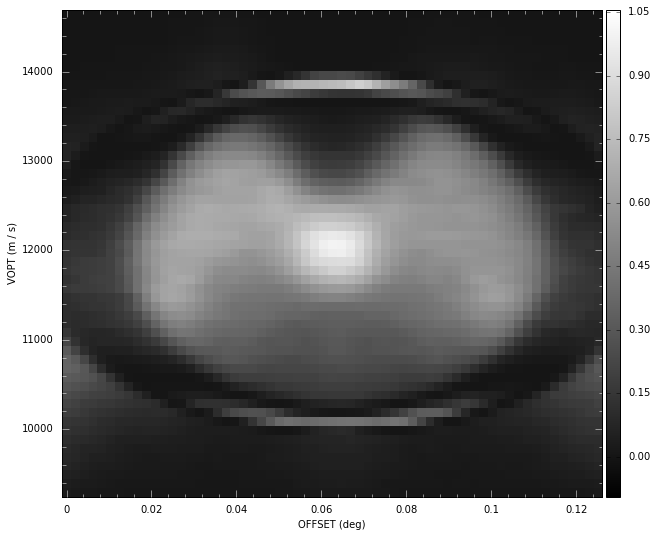

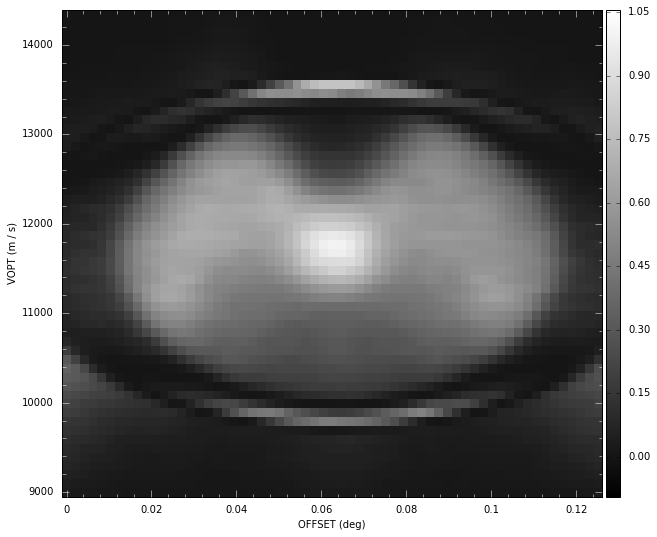

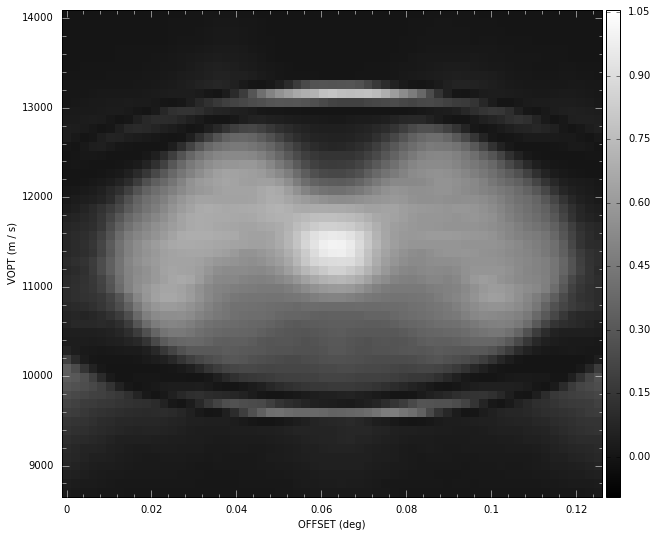

In [427]:
outfile = '../turbulent_model/shell18_particles.fits'
rms_grid = []
cube_obs = subcube_12co.subcube('min', 'max', 'min', 'max',
                                 cube_model.spectral_extrema[0],
                                 cube_model.spectral_extrema[1]
                               )

pv_width = 3. * pars['pix_size']
#pv_length = 3. * (pars['R'] / pars['dist'])*u.rad
pv_length = 3. * shell.radius
pv_average_obs = shells.pv_average(
    cube=cube_obs,#cube_obs.spectral_slab(cube_model.spectral_extrema[0], cube_model.spectral_extrema[1]),
    ra_center=pars['acen'], dec_center=pars['dcen'],
    width=pv_width, length=pv_length, angle_step=90.*u.deg)


for R in R_grid:
    print(R)
    pars = {
        'outfile':"'{}'".format(outfile),
        'dist':414*u.pc, # pc
        'pix_size':7.5*u.arcsec, # arcsec
        'vstep':0.099*u.km/u.s, # km/s
        'acen':shell.ra, # deg
        'dcen':shell.dec, # deg
        'R':R*u.pc, # pc
        'dr':0.15*u.pc, # pc
        'vexp':2.2*u.km/u.s, # km/s
        'v0':13.6*u.km/u.s, # km/s
        'method':'sample',
        'write_fits':False,
        'samples_per_voxel':27,
        'pad_channels':5
        }
    
    cube_model = SpectralCube.read(shell_model.ppv_model(**pars))
    # cube_obs = subcube_12co.subcube(cube_model.longitude_extrema[1],
    #                                 cube_model.longitude_extrema[0],
    #                                 cube_model.latitude_extrema[0],
    #                                 cube_model.latitude_extrema[1],
    #                                 cube_model.spectral_extrema[0],
    #                                 cube_model.spectral_extrema[1])
   
    #cube_model = cube_model.reproject(cube_obs.header)
    cube_model /= cube_model.max()
    cube_obs /= cube_obs.max()
    #cube_model.header

    pv_model = shells.pv_slice(cube=cube_model, ra_center=pars['acen'],
                           dec_center=pars['dcen'], angle=0*u.deg,
                           width=pv_width, length=pv_length)

    model = np.nan_to_num(pv_model.data, copy=False)
    obs = np.nan_to_num(pv_average_obs.data, copy=False)
    model = model/np.max(model)
    #model[model > 0.] = 1.
    obs = obs/np.max(obs)

    
    pv_resid =  obs - model
    pv_resid[obs < 0.01] = np.nan
    resid_squared = pv_resid ** 2.

    fig = FITSFigure(fits.PrimaryHDU(resid_squared, header=pv_model.header))
    g = fig.show_grayscale()
    cb = fig.show_colorbar()
    rms_grid = np.append(rms_grid, np.sqrt(np.nanmean(resid_squared)))
    print("RMS Residual =", np.sqrt(np.nanmean(resid_squared)))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                   53                                                  
NAXIS2  =                   53                                                  
NAXIS3  =                   55                                                  
NAXIS1  =                   53                                                  
NAXIS3  =                   55                                                  
THICK   =                  0.0 / Cloud Thickness (pc)                           
DIST    =                414.0 / Distance to cloud (pc)                         
V_FWHM  =                  0.0 / Cloud velocity spread (km/s)                   
BETA    =                  0.0 / Cloud velocity power spectrum index            
VEXP    =                  2